# サポートベクトルマシン

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import matplotlib.colors
from IPython.display import HTML

**サポートベクトルマシン**（SVM: Support Vector Machines）は、「マージン最大化」や「カーネルトリック」などの興味深い特徴を持つ回帰・分類モデルである。元となるアイディアは1963年に発表されたが、1990年代に研究が進み、2000年頃から回帰や分類でよく用いられるようになった。ニューラルネットワークと同様に、非線形な分類器を構築できる。この章では、ハード・マージン・サポートベクトルマシンを通して、基本的なアイディアを説明したい。なお、この章の説明では {cite:t}`SVM` を参考にした。

なお、この章においてグラフの描画に用いられるユーティリティ関数は、以下の隠しセルで定義されている。どのようにグラフを描画しているのか把握できるように、説明の箇所では関数呼び出しのプログラムのみを示している。呼び出される関数の実装については、以下のセルを参照せよ。

In [2]:
def find_range(Xx, Xy):
    xmin, xmax = Xx.min() - 0.1, Xx.max() + 0.1
    ymin, ymax = Xy.min() - 0.1, Xy.max() + 0.1
    if xmax - xmin < ymax - ymin:
        xmid = (xmax + xmin) / 2
        xmin = xmid - (ymax - ymin) / 2
        xmax = xmid + (ymax - ymin) / 2
    else:
        ymid = (ymax + ymin) / 2
        ymin = ymid - (xmax - xmin) / 2
        ymax = ymid + (xmax - xmin) / 2
    return ((xmin, xmax), (ymin, ymax))

def init_graph(X, Y, dpi=100, figsize=(6,6)):
    (xmin, xmax), (ymin, ymax) = find_range(X[:,0], X[:,1])
    fig, ax = plt.subplots(dpi=dpi, figsize=figsize)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    return fig, ax

def plot_data(ax, X, Y):
    I = np.where(Y == -1)
    ax.scatter(X[I,0], X[I,1], c='tab:blue', marker='_')
    I = np.where(Y == 1)
    ax.scatter(X[I,0], X[I,1], c='tab:red', marker='+')

def draw_line(ax, wx, wy, b, ls, name='', color='tab:gray'):
    def f(x, wx, xy, b):
        return - wx / wy * x - b / wy
    
    x = np.array(ax.get_xlim())
    y = f(x, wx, wy, b)
    ax.plot(x, y, color=color, ls=ls, label=f'{name}')

def draw_margins(ax, wx, wy, Xx, Xy, svn, svp, s=None):
    length = np.sqrt(wx ** 2 + wy ** 2)
    margin = 1 / length

    for i in svn:
        x, y = Xx[i], Xy[i]
        ax.scatter([x], [y], s=s, facecolors='none', edgecolors='tab:blue')
        ax.plot([x, x + wx * margin / length], [y, y + wy * margin / length], ls=':', color='tab:blue')
        
    for i in svp:
        x, y = Xx[i], Xy[i]
        ax.scatter([x], [y], s=s, facecolors='none', edgecolors='tab:red')
        ax.plot([x, x - wx * margin / length], [y, y - wy * margin / length], ls=':', color='tab:red')

def plot_support_vectors(ax, X, Y, svs, s=None):
    for i in svs:
        color = 'tab:red' if Y[i] == 1 else 'tab:blue'
        ax.scatter([X[i][0]], [X[i][1]], s=s, facecolors='none', edgecolors=color)

def draw_heatmap(ax, fig, X, Y, model, step=1, N=1024):
    (xmin, xmax), (ymin, ymax) = find_range(X[:,0], X[:,1])
    XX, YY = np.meshgrid(np.linspace(xmin, xmax, N), np.linspace(ymin, ymax, N))
    XY = np.vstack([XX.ravel(), YY.ravel()]).T
    C = model.decision_function(XY).reshape(XX.shape)

    vmin, vmax = C.min(), C.max()
    vmin = ((vmin // step) - 1) * step
    vmax = ((vmax // step) + 1) * step
    width = max(abs(vmin), abs(vmax))
    
    mesh = ax.pcolormesh(XX, YY, C, norm=matplotlib.colors.Normalize(vmin=-width, vmax=width), cmap='bwr', shading='auto', alpha=0.2)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Output value')
    
    cont = ax.contour(XX, YY, C, colors='tab:gray', linewidths=0.5, linestyles='dashed', levels=np.arange(vmin, vmax+1, step))
    cont.clabel(fmt='%1.1f')

## 線形モデル

まず、線形モデルによる二値分類を説明する。$d$次元ベクトルで表される事例$\pmb{x} \in \mathbb{R}^d$に対して、二値のクラス$\hat{y} \in \{+1, -1\}$を次式で予測する。

:::{admonition} 線形モデルのラベル推定式
:class: important
\begin{align}
\hat{y} = \begin{cases}
+1 & (\pmb{w}^\top\pmb{x} + b > 0) \\
-1 & (\pmb{w}^\top\pmb{x} + b \leq 0)
\end{cases}
\end{align}
:::

ここで、重みベクトル$\pmb{w} \in \mathbb{R}^d$と$b \in \mathbb{R}$はモデルのパラメータである。なお、この判別式はロジスティック回帰のものと同様であるが、今後の数式の表記をシンプルにするため、クラス（目的変数が取りうる値）の定義を$\{1, 0\}$から$\{+1, -1\}$に変更した。

事例ベクトル$\pmb{x}_i \in \mathbb{R}^d$とその正解クラス$y_i \in \{+1, -1\}$の組で訓練事例が表現され、$N$個の事例からなる訓練データ$\mathcal{D} = \{(\pmb{x}_i, y_i)\}_{i=1}^N$が与えられる。また、簡単のため訓練データは線形分離可能であると仮定する。例として、$d=2$（2次元）で$50$事例からなる訓練データを考える。

In [3]:
from sklearn.datasets import make_blobs
X, Y = make_blobs(n_samples=50, centers=2, random_state=129, cluster_std=.6)
Y = Y * 2 - 1

この訓練データの$\pmb{x} \in \mathbb{R}^2$を2次元平面上にプロットする。この章では、正例（$y = +1$）は＋印（赤色）で、負例（$y = -1$）はー印で示す。

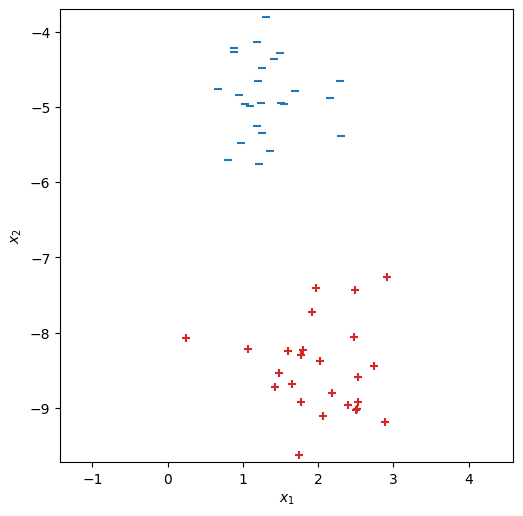

In [4]:
fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
plt.show()

### マージン最大化

さて、線形モデルのパラメータ$\pmb{w}$と$b$の値が決まると、$\hat{y}$を$+1$と$-1$に識別する分離平面を描くことができる。以下の可視化では、$\pmb{w}$と$b$の値を適当にセットし、３本の分離平面を描いた。今回のデータは$2$次元であるため、分離平面は直線で表現される。この中でどの分離平面が良さそうであろうか？

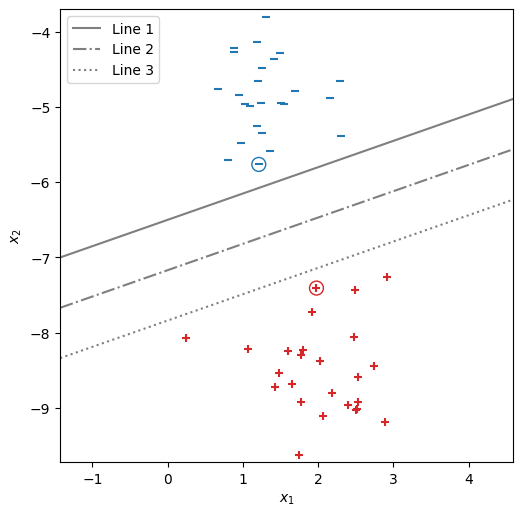

In [5]:
fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
plot_support_vectors(ax, X, Y, [4, 40], s=100)
draw_line(ax, 0.366, -1.046, -6.8, '-', 'Line 1')
draw_line(ax, 0.366, -1.046, -7.5,  '-.', 'Line 2')
draw_line(ax, 0.366, -1.046, -8.2, ':', 'Line 3')
plt.legend(loc='upper left')
plt.show()

この３つの分離平面は、学習事例の全てを正しく分類できている。ところが、汎化性能の高い分類器を作るという観点では、学習データに現れていない点を正しく分類できるかどうかが重要である。言い換えれば、上のグラフでプロットされていない領域の分類結果が合理的なものになりそうか、検討しなければならない。

まず、一番上の分離平面 "Line 1" を考える。その分離平面の近くに丸印を付けた負例がある。もし（未知の）事例がその負例の周辺に現れた場合、$\hat{y}=-1$に分類することが合理的である。ところが、この分離平面は丸印の負例の点のすぐ近くにあるため、その点の下側では$\hat{y}=+1$と分類されてしまう恐れがある。
続いて、一番下の分離平面 "Line 3" を考える。その分離平面の近くに丸印を付けた正例がある。もし（未知の）事例がその正例の周辺に現れた場合、$\hat{y}=+1$に分類することが合理的である。ところが、この分離平面が正例のすぐ近くにあるため、その点の上側では$\hat{y}=-1$と分類されてしまう恐れがある。

サポートベクトルマシンでは、すべての学習事例を正しく分類でき、かつ全ての学習事例から離れた分離平面は、高い汎化性能を持つと仮定する。全学習事例と分離平面との距離を定量化するため、全学習事例から分離平面に垂線を降ろし、その距離の最小値を**マージン**（margin）として定義する。サポートベクトルマシンの学習は、与えられた学習データに対してマージンを最大にする分離平面を求めることである。

マージンを最大化するという観点では、先ほどの３つの分離平面の中では真ん中が最も良さそうである。また、この可視化が示唆するように、分離平面を$y=-1$の事例から遠ざけると、$y=+1$の事例に近づくことになる。この均衡があるため、マージンが最大になるように分離平面を求めた時、マージンの計算に関与する事例（垂線の距離が最小になる事例）は、$y=\pm 1$の双方のクラスにおいて少なくとも1つずつ存在する。

今度は、傾きの異なる３つの直線を分離平面として引いた。この中でマージンが最も大きくなるのはどの直線であろうか？　真ん中の分離平面 "Line 2" であることは明白であろう。

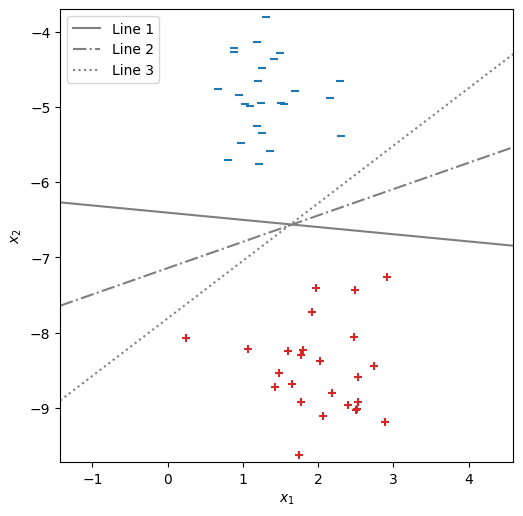

In [6]:
fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
draw_line(ax, -0.1, -1.046, -6.7, '-', 'Line 1')
draw_line(ax, 0.366, -1.046, -7.471, '-.', 'Line 2')
draw_line(ax, 0.8, -1.046, -8.17, ':', 'Line 3')
plt.legend(loc='upper left')
plt.show()

この中央の分離平面 "Line 2" に着目して書き直したのが、下のグラフである。このグラフでは、分離平面を黒色の実線で示した。マージンの計算に関与する事例は、$y = +1$側に1つ（丸印付きの＋）、$y = -1$側に2つ（丸印付きのー）ある。このマージンの計算に関与する事例を**サポートベクトル**と呼ぶ。サポートベクトルから分離平面に降ろした垂線を点線で示した。実は、この分離平面は訓練事例に対してサポートベクトルマシンを学習した結果得られたものである。したがって、このような分離平面に対応するパラメータ$\pmb{w}, b$を求めることが、以降の議論の中心である。

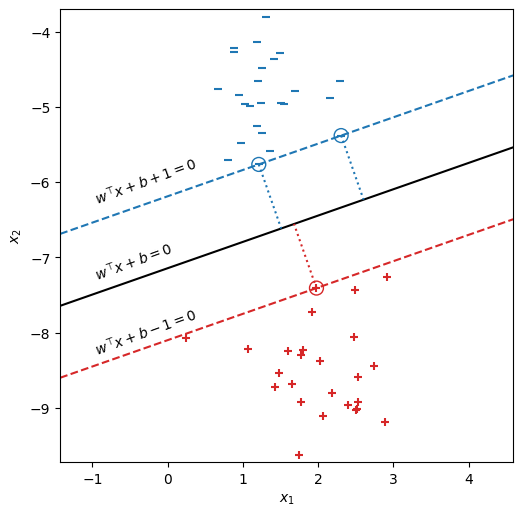

In [7]:
wx, wy, b = 0.36586586, -1.04568619, -7.470506295184168

fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
draw_line(ax, wx, wy, b, '-', color='black')
draw_line(ax, wx, wy, b+1, '--', color='tab:blue')
draw_line(ax, wx, wy, b-1, '--', color='tab:red')
draw_margins(ax, wx, wy, X[:,0], X[:,1], [4, 30], [40], s=100)
ax.text(-1, -6.3, r'$w^\top x + b + 1 = 0$', rotation=20)
ax.text(-1, -7.3, r'$w^\top x + b = 0$', rotation=20)
ax.text(-1, -8.3, r'$w^\top x + b - 1 = 0$', rotation=20)
plt.show()

いま、$y = +1$のサポートベクトルを適当に選び、$\pmb{x}_{+}$と書くことにする、また、$y = -1$のサポートベクトルも適当に選び、$\pmb{x}_{-}$と書くことにする。さらに、パラメータ$\pmb{w}$の値を適当に設定したとする。なお、パラメータ$\pmb{w}$を設定したことにより、分離平面は$\pmb{w}$に直交するものの中から選ぶことになる。

マージンを$h$とおくと、その長さの2倍は$\pmb{x}_{-}$から$\pmb{x}_{+}$への向きベクトルを分離平面の法線ベクトル$\pmb{w}$に射影した長さに等しいので、

```{margin} 射影ベクトルの長さ
始点が同じベクトル$\pmb{a}, \pmb{b}$があり、そのなす角を$\theta$とする。ベクトル$\pmb{a}$を$\pmb{b}$に射影したベクトルの長さは、

\begin{align*}
|\pmb{a}|\cos \theta = |\pmb{a}| \frac{\pmb{a} \cdot \pmb{b}}{|\pmb{a}| |\pmb{b}|} = \frac{\pmb{a} \cdot \pmb{b}}{|\pmb{b}|}
\end{align*}
```

\begin{align}
2h &= \frac{|(\pmb{x}_{+} - \pmb{x}_{-})^\top \pmb{w}|}{\|\pmb{w}\|} \\
h &= \frac{|(\pmb{x}_{+} - \pmb{x}_{-})^\top \pmb{w}|}{2\|\pmb{w}\|}
\end{align}

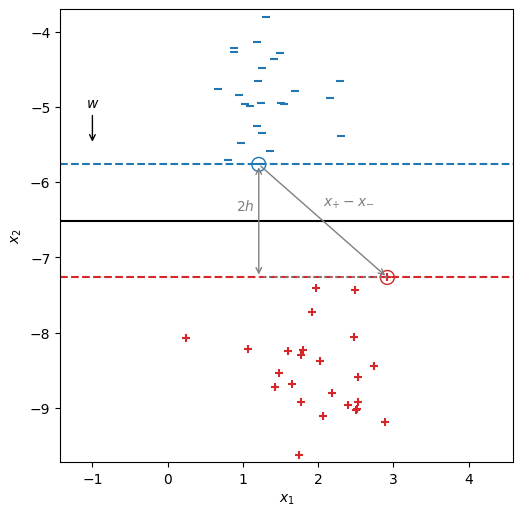

In [8]:
def solve(dx, dy, xp, xn):
    # This function solves:
    #   c \cdot d \cdot xp + b = 1
    #   c \cdot d \cdot xn + b = -1
    d = np.array([dx, dy])
    wxp = np.dot(d, xp)
    wxn = np.dot(d, xn)
    c = 2 / (wxp - wxn)
    b = 1 - c * wxp
    return (dx * c, dy * c, b)

xp = X[23]
xn = X[4]
dx, dy = 0.0, -0.5
wx, wy, b = solve(dx, dy, xp, xn)
base = np.array([-1, -5])

w = np.array([wx, wy])
h = np.abs(np.dot(xp - xn, w)) / (2 * np.linalg.norm(w))
xn2 = xn + 2 * h * w / np.linalg.norm(w)

fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
draw_line(ax, wx, wy, b, '-', color='black')
draw_line(ax, wx, wy, b+1, '--', color='tab:blue')
draw_line(ax, wx, wy, b-1, '--', color='tab:red')
plot_support_vectors(ax, X, Y, [4, 23], s=100)
ax.annotate('$w$', base + np.array([dx, dy]), base, ha='center', arrowprops={'arrowstyle': '->'})
ax.annotate('', xp, xn, arrowprops=dict(arrowstyle='->', color='tab:gray'))
ax.text((xn[0] + xp[0]) / 2, (xn[1] + xp[1]) / 2 + 0.2, '$x_{+} - x_{-}$', color='tab:gray')
ax.annotate('', xn2, xn, arrowprops=dict(arrowstyle='<->', color='tab:gray'))
ax.text(xn[0] - 0.3, (xn[1] + xn2[1]) / 2 + 0.2, '$2h$', va='center', color='tab:gray')
ax.plot([xp[0], xn2[0]], [xp[1], xn2[1]], ls=':', color='tab:gray')
plt.show()

したがって、この$h$を最大にする$\pmb{w}$や$b$を求めればよい。ところが、マージン$h$を求める式は、$\pmb{w}$を定数倍しても値が変わらない。すなわち、$\pmb{w}$を$\gamma$倍してからマージンを求めても、分子と分母で$\gamma$が打ち消されるだけである。

\begin{align}
h &= \frac{|(\pmb{x}_{+} - \pmb{x}_{-})^\top (\gamma\pmb{w})|}{2\|\gamma\pmb{w}\|} = \frac{\gamma|(\pmb{x}_{+} - \pmb{x}_{-})^\top (\pmb{w})|}{2\gamma\|\pmb{w}\|} = \frac{|(\pmb{x}_{+} - \pmb{x}_{-})^\top \pmb{w}|}{2\|\pmb{w}\|}
\end{align}

言い換えれば、現状のマージン最大化の定式化では、求まる$\pmb{w}$や$b$に関して任意性が残っている。そこで、サポートベクトルに対応する事例$\pmb{x}_{+}, \pmb{x}_{-}$に対して、以下の式が成り立つこととし、$\pmb{w}$と$b$の任意性を除去する。
\begin{align}
\pmb{w}^\top\pmb{x}_{+} + b = +1 &\Leftrightarrow \pmb{w}^\top\pmb{x}_{+} + b - 1 = 0\\
\pmb{w}^\top\pmb{x}_{-} + b = -1 &\Leftrightarrow \pmb{w}^\top\pmb{x}_{-} + b + 1 = 0\\
\end{align}
この$\pmb{w}^\top\pmb{x} + b - 1 = 0$の直線を赤の破線で、$\pmb{w}^\top\pmb{x} + b + 1 = 0$の直線を青の破線で示した。

以上の取り決めを導入したことにより、$y_i = +1$である学習事例は、
\begin{align}
\pmb{w}^\top\pmb{x}_i + b \geq 1
\end{align}
を満たし、$y_i = -1$である学習事例は
\begin{align}
\pmb{w}^\top\pmb{x}_i + b \leq -1
\end{align}
を満たす必要がある。なお、この２つの条件式は、$y_i$を使って次のようにまとめることができる。
\begin{align}
y_i (\pmb{w}^\top\pmb{x}_i + b) \geq 1
\end{align}

さて、マージンを求める式にサポートベクトルが満たすべき条件を代入すると、
\begin{align}
h &= \frac{|(\pmb{x}_{+} - \pmb{x}_{-})^\top \pmb{w}|}{2\|\pmb{w}\|} \\
&= \frac{|\pmb{x}_{+}^\top \pmb{w} - \pmb{x}_{-}^\top \pmb{w}|}{2\|\pmb{w}\|} \\
&= \frac{|(1-b) - (-1-b)|}{2\|\pmb{w}\|} \\
&= \frac{2}{2\|\pmb{w}\|} \\
&= \frac{1}{\|\pmb{w}\|} \\
\end{align}

ゆえに、サポートベクトルマシンの学習は以下の制約付き最適化問題でパラメータ$\pmb{w}^*, b^*$を求める問題に帰着する。
\begin{gather}
\pmb{w}^*, b^* = \mathop{\rm argmax}\limits_{\pmb{w}, b} \frac{1}{\|\pmb{w}\|} \\
\text{subject to } \forall i \in \{1, \dots N\}: y_i (\pmb{w}^\top\pmb{x}_i + b) - 1 \geq 0
\end{gather}

最大化問題を最小化問題に変更し、数学的な取り扱いの都合で目的関数に$\frac{1}{2}$を付けると、サポートベクトルマシンの学習のための最小化問題は次式で表される。

:::{admonition} サポートベクトルマシンの主問題
:class: important

\begin{gather}
\pmb{w}^*, b^* = \mathop{\rm argmin}\limits_{\pmb{w}, b} \frac{1}{2}\|\pmb{w}\|^2 \\
\text{subject to } \forall i \in \{1, \dots N\}: y_i (\pmb{w}^\top\pmb{x}_i + b) - 1 \geq 0
\end{gather}

:::

なお、この最適化問題ではパラメータ$b$が最小化に関与しないように見えるが、$\pmb{w}$が変化すると制約を満たすために$b$を変更する必要がある。

## 制約付き最適化

この不等式制約付き最小化問題を解くため、ラグランジュの未定乗数法を用いる。
\begin{align}
L(\pmb{w}, b, \pmb{a}) = \frac{1}{2}\|\pmb{w}\|^2 - \sum_{i=1}^{N} \alpha_i \left\{y_i (\pmb{w}^\top\pmb{x}_i + b) - 1\right\}
\end{align}
ここで、$\alpha_1, \dots, \alpha_N \geq 0$はラグランジュ乗数であり、これらをまとめてベクトル$\pmb{a}$で表す。
\begin{align}
\pmb{a} = \begin{pmatrix}a_1, \dots, a_N\end{pmatrix}^\top
\end{align}

ラグランジュ関数$L(\pmb{w}, b, \pmb{a})$を最小化するため、$\pmb{w}$で偏微分して$0$とおくと、
\begin{align}
\frac{\partial L(\pmb{w}, b, \pmb{a})}{\partial \pmb{w}} = \pmb{w} - \sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i &= 0 \\
\pmb{w} &= \sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i
\end{align}

また、ラグランジュ関数$L(\pmb{w}, b, \pmb{a})$を$b$で偏微分して$0$とおくと、
\begin{align}
\frac{\partial L(\pmb{w}, b, \pmb{a})}{\partial b} = - \sum_{i=1}^{N} \alpha_i y_i  &= 0 \\
\sum_{i=1}^{N} \alpha_i y_i &= 0
\end{align}

この結果を元のラグランジュ関数に代入して整理すると、$\pmb{a}$に関する最小化問題が得られる。この目的関数は元の目的関数の**双対問題**（dual problem）と呼ばれる。
\begin{align}
L(\pmb{a}) &= \frac{1}{2}\left(\sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i\right) \cdot \left(\sum_{j=1}^{N} \alpha_j y_j \pmb{x}_j\right)  - \sum_{i=1}^{N} \alpha_i \left[y_i \left\{\left(\sum_{j=1}^{N} \alpha_j y_j \pmb{x}_j\right) \cdot \pmb{x}_i + b\right\} - 1\right] \\
&= \frac{1}{2}\left(\sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i\right) \cdot \left(\sum_{j=1}^{N} \alpha_j y_j \pmb{x}_j\right)  - \left(\sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i\right) \cdot \left(\sum_{j=1}^{N} \alpha_j y_j \pmb{x}_j\right) - b\underbrace{\sum_{i=1}^{N} \alpha_i y_i}_{=0} + \sum_{i=1}^{N} \alpha_i \\
&= \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\left(\sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i\right) \cdot \left(\sum_{j=1}^{N} \alpha_j y_j \pmb{x}_j\right) \\
&= \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j \pmb{x}_i^\top \pmb{x}_j \\
\end{align}


まとめると、サポートベクトルマシンの学習の双対問題は以下の通りである。

:::{admonition} サポートベクトルマシンの双対問題
:class: important

\begin{gather}
\pmb{a}^* = \mathop{\rm argmin}\limits_{\pmb{a}} \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j \pmb{x}_i^\top \pmb{x}_j \\
\text{subject to } \forall i \in \{1, \dots N\}: a_i \geq 0 \\
\sum_{i=1}^{N} \alpha_i y_i = 0
\end{gather}

:::

この最小化問題は二次計画法で解くことができ、サポートベクトルマシンでは逐次最小問題最適化法（SMO: Sequential Minimal Optimization）などが解法アルゴリズムとして用いられる。ただし、ここではその解法の詳細は省略する。

双対問題を最小にする解$\pmb{a}^*$を求めたのち、ラグランジュ関数$L(\pmb{w}, b, \pmb{a})$を$\pmb{w}$で偏微分して$0$とおいた結果から、以下の式で$\pmb{w}^*$を求めればよい。
\begin{align}
\pmb{w}^* &= \sum_{i=1}^{N} \alpha^*_i y_i \pmb{x}_i
\end{align}

なお、ラグランジュの未定乗数法におけるKarush-Kuhn-Tucker (KKT) 条件により、以下の条件が成り立つ。
\begin{align}
y_i (\pmb{w}^\top\pmb{x}_i + b) - 1 \geq 0 \\
\alpha_i \geq 0 \\
\alpha_i \left\{y_i (\pmb{w}^\top\pmb{x}_i + b) - 1\right\} = 0 \\
\end{align}
この3番目の条件から、$y_i (\pmb{w}^\top\pmb{x}_i + b) > 1$が成り立つ事例$\pmb{x}_i, y_i$、すなわちサポートベクトルではない事例に対しては、$a_i = 0$が必ず成立することが分かる。ゆえに、$\pmb{w}^*$を求める式は、学習データ中の少数のサポートベクトルの重み付き和で表現され、サポートベクトル以外の事例は$\pmb{w}^*$の計算に影響を与えない。$b^*$は、求めたサポートベクトルのいずれかに対して、
\begin{align}
\pmb{w}^* \cdot \pmb{x}_{-} + b = 0 \\
b = -\pmb{w}^* \cdot \pmb{x}_{-}
\end{align}
と求めればよい。

## 線形SVMの学習例

[sklearn.svm.SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)を用いて、例として用いた学習データで線形モデルを学習する。

In [9]:
from sklearn.svm import SVC
model = SVC(kernel='linear')
model.fit(X, Y)

SVC(kernel='linear')

学習で求めたパラメータ$\pmb{w}, b$を用い、$\pmb{w}^\top\pmb{x} + b$の等高線を描いたうえで、学習事例をプロットする。なお、サポートベクトルは丸印で表示している。サポートベクトルが等高線上で$\pm 1$の直線上に乗っていることが確認できる。

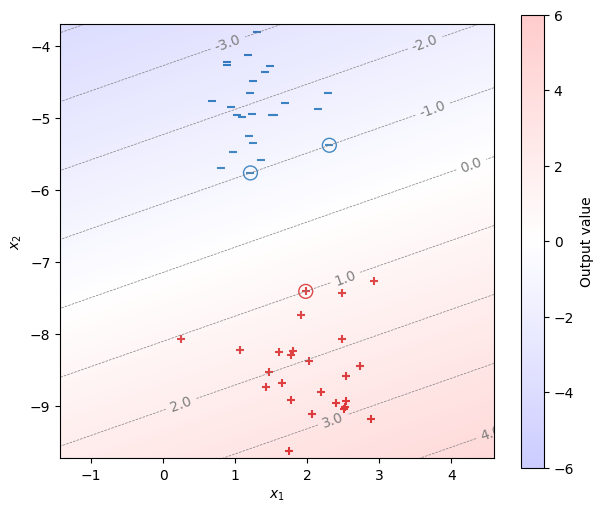

In [10]:
fig, ax = init_graph(X, Y, figsize=(7, 6))
plot_data(ax, X, Y)
plot_support_vectors(ax, X, Y, model.support_, s=100)
draw_heatmap(ax, fig, X, Y, model)
plt.show()

学習により求められた$\pmb{w}$と$b$を確認する。

In [11]:
model.coef_[0], model.intercept_[0]

(array([ 0.36586586, -1.04568619]), -7.470506295184168)

サポートベクトルとなった事例のインデックス番号を確認する。

In [12]:
model.support_

array([ 4, 30, 40], dtype=int32)

上で示した事例に対応する$\alpha_i$の値を確認する。なお、この`dual_coef_`では$y_i$の値がかけられているため、負の値を取ることがある。

In [13]:
model.dual_coef_[0]

array([-0.51806476, -0.0957497 ,  0.61381447])

念のため、$\sum_{i=1}^{N} \alpha_i y_i = 0$が満たされているか確認する。

In [14]:
np.sum(model.dual_coef_[0])

2.220446049250313e-16

念のため、$\pmb{w} = \sum_{i=1}^{N} \alpha_i y_i \pmb{x}_i$で重みベクトル$\pmb{w}$を求めてみる。

In [15]:
model.dual_coef_[0] @ X[model.support_]

array([ 0.36586586, -1.04568619])

## カーネルSVM

さて、入力の特徴ベクトル$\pmb{x}$に非線形変換を施し、非線形な分類モデルを構成することを考える。非線形変換を行う関数を$\pmb{\phi}: \mathbb{R}^d \mapsto \mathbb{R}^{r}$とすると、このモデルのパラメータはベクトル$\pmb{w} \in \mathbb{R}^{r}$とバイアス項$b$となる。線形の場合と同様に、事例$\pmb{x}$に対して分類器が予測するクラス$\hat{y}$は、
\begin{align}
\hat{y} = \begin{cases}
+1 & (\pmb{w}^\top\pmb{\phi}(\pmb{x}) + b > 0) \\
-1 & (\pmb{w}^\top\pmb{\phi}(\pmb{x}) + b \leq 0)
\end{cases}
\end{align}

このモデルは、事例の特徴ベクトル$\pmb{x}$を$\pmb{\phi}(\pmb{x})$に置き換えただけであるから、サポートベクトルマシンの学習の双対問題は、
\begin{gather}
\pmb{a}^* = \mathop{\rm argmin}\limits_{\pmb{a}} \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j \pmb{\phi}(\pmb{x}_i)^\top \pmb{\phi}(\pmb{x}_j) \\
\text{subject to } \forall i \in \{1, \dots N\}: a_i \geq 0 \\
\sum_{i=1}^{N} \alpha_i y_i = 0
\end{gather}

ここで、
\begin{align}
K(\pmb{x}_i, \pmb{x}_j) = \pmb{\phi}(\pmb{x}_i)^\top \pmb{\phi}(\pmb{x}_j)
\end{align}
とおくと、先ほどの問題を以下の式で表現できる。

:::{admonition} カーネル関数によるサポートベクトルマシンの双対問題
:class: important

\begin{gather}
\pmb{a}^* = \mathop{\rm argmin}\limits_{\pmb{a}} \sum_{i=1}^{N} \alpha_i - \frac{1}{2}\sum_{i=1}^{N} \sum_{j=1}^{N} \alpha_i \alpha_j y_i y_j K(\pmb{x}_i, \pmb{x}_j) \\
\text{subject to } \forall i \in \{1, \dots N\}: a_i \geq 0 \\
\sum_{i=1}^{N} \alpha_i y_i = 0
\end{gather}

:::

これは単なる置換に思えるかもしれないが、重要な意味を持つ。サポートベクトルマシンの学習では、$\pmb{\phi}(\pmb{x})$を求めなくても、全事例の組み合わせに対して$K(\pmb{x}_i, \pmb{x}_j)$が求められれば十分である。$K$は**カーネル関数**と呼ばれる。機械学習において$\pmb{\phi}(\pmb{x})$を陽に計算せず、カーネル関数の計算だけで済ませてしまうことは、**カーネル・トリック**と呼ばれる。

ここでは、よく用いられるカーネル関数を紹介する。

### 線形カーネル

\begin{align}
K(\pmb{u}, \pmb{v}) = \pmb{u}^\top\pmb{v}
\end{align}

このカーネルに対応する変換は$\pmb{\phi}(\pmb{x}) = \pmb{x}$である（つまり、これまでに導出した線形SVMそのものである）。

### 多項式カーネル

\begin{align}
K(\pmb{u}, \pmb{v}) = (\pmb{u}^\top\pmb{v} + c)^m
\end{align}

$m=2$の場合、
\begin{align}
K(\pmb{u}, \pmb{v}) &= (\pmb{u}^\top\pmb{v} + c)^2 \\
&= (\pmb{u}^\top\pmb{v})^2 + 2 c (\pmb{u}^\top\pmb{v}) + c^2 \\
&= (u_1 v_1 + u_2 v_2 + \dots u_d v_d)^2 + 2 c (u_1 v_1 + u_2 v_2 + \dots u_d v_d) + c^2 \\
&= \sum_{i=1}^d u_i^2 v_i^2 + \sum_{i=1}^d \sum_{j=i+1}^d 2 u_i u_j v_i v_j + \sum_{i=1}^d 2 c u_i v_i + c^2 \\
&= \sum_{i=1}^d (u_i^2) (v_i^2) + \sum_{i=1}^d \sum_{j=i+1}^d (\sqrt{2} u_i u_j) (\sqrt{2} v_i v_j) + \sum_{i=1}^d (\sqrt{2 c} u_i) (\sqrt{2c} v_i) + c^2 \\
\end{align}
であるから、このカーネルに対応する変換は、
\begin{align}
\pmb{\phi}(\pmb{x}) = \begin{pmatrix} x_1^2 & \dots & x_d^2 & \sqrt{2} x_1 x_2 & \dots & \sqrt{2} x_{d-1} x_d & \sqrt{2 c} x_1 & \dots & \sqrt{2 c} x_d & c\end{pmatrix}
\end{align}
すなわち、２次の多項式カーネル$K(\pmb{u}, \pmb{v}) = (\pmb{u}^\top\pmb{v} + c)^2$を用いることは、$d$次元の特徴ベクトル$\pmb{x}$から、各要素の二乗、２つの要素同士の積、各要素を$\pmb{\phi}(\pmb{x})$で取り出すことに相当する。

### Radial Basis Function (RBF)

\begin{align}
K(\pmb{u}, \pmb{v}) = \exp\left(-\gamma|\pmb{u}-\pmb{v}|^2\right)
\end{align}

[RBFカーネル](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)に対応する変換は無限次元になり得る。

### カーネル関数を用いた予測

カーネル関数を用いて事例ベクトル$\pmb{x}$を$\hat{y} = +1$か$-1$に識別する式は、以下のように整理できる。

$$

\begin{align}
\pmb{w}^\top\pmb{\phi}(\pmb{x}) + b &= \left(\sum_{i=1}^{N} \alpha^*_i y_i \pmb{\phi}(\pmb{x}_i)\right) \cdot \pmb{\phi}(\pmb{x}) \\
&= \sum_{i=1}^{N} \alpha^*_i y_i \pmb{\phi}(\pmb{x}_i) \cdot \pmb{\phi}(\pmb{x}) \\
&= \sum_{i=1}^{N} \alpha^*_i y_i K(\pmb{x}_i, \pmb{x}) \\
\end{align}

$$ (eq:svm-decision-function)

したがって、サポートベクトルと事例ベクトルとの間でカーネル関数の値を計算できれば、やはり特徴空間を陽に求めなくても事例の分類を行える。

## カーネルSVMの学習例

事例数$N=100$、入力$\pmb{x}$の次元数$d_{\rm in}=2$の二値分類の訓練データを用意する（このデータは線形分離不能である）。

In [16]:
from sklearn.datasets import make_circles
X, Y = make_circles(100, factor=.1, noise=.1)
Y = Y * 2 - 1

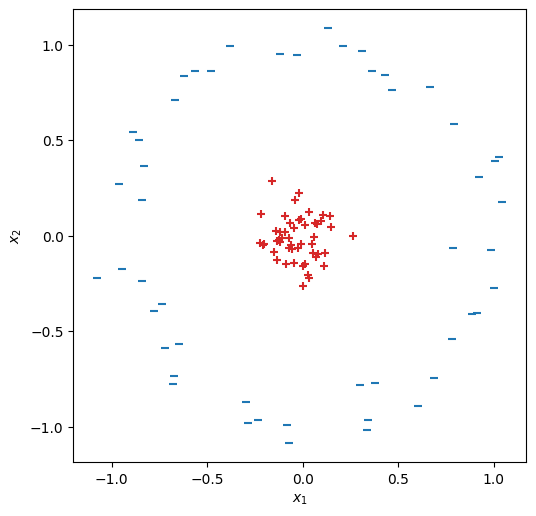

In [17]:
fig, ax = init_graph(X, Y)
plot_data(ax, X, Y)
plt.show()

このデータは$z = x_1^2 + x_2^2$の非線形変換を施すことにより、簡単に分離できる。

In [20]:
Z = np.exp(-(X ** 2).sum(1))
(xmin, xmax), (ymin, ymax) = find_range(X[:,0], X[:,1])

fig = plt.figure(dpi=100, figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$z$')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

I = np.where(Y == -1)
ax.scatter(X[I,0], X[I,1], Z[I], c='tab:blue', marker='_')
I = np.where(Y == 1)
ax.scatter(X[I,0], X[I,1], Z[I], c='tab:red', marker='+')

def update(i, ax):
    ax.view_init(elev=90-i*2, azim=45)

ani = matplotlib.animation.FuncAnimation(fig, update, fargs=(ax,), interval=100, frames=46)
html = ani.to_jshtml()
plt.close(fig)
HTML(html)

カーネル関数を用いたSVMでは、この非線形変換を陽に与えずに、カーネル関数の形だけを指定して非線形分類を行う。以下は2次の多項式カーネルを用いる例である。

In [21]:
model = SVC(kernel='poly', degree=2, C=1e6)
model.fit(X, Y)

SVC(C=1000000.0, degree=2, kernel='poly')

式{eq}`eq:svm-decision-function`を用いて、決定関数（$\pmb{w}^\top\pmb{\phi}(\pmb{x}) + b$）の値をヒートマップで描画する。

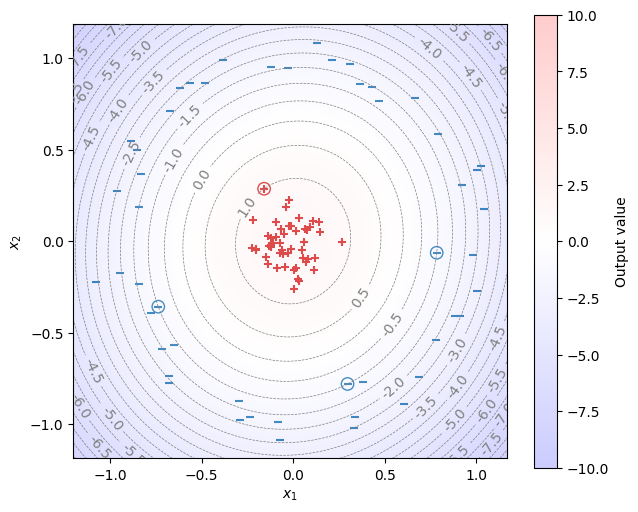

In [22]:
fig, ax = init_graph(X, Y, figsize=(7, 6))
plot_data(ax, X, Y)
plot_support_vectors(ax, X, Y, model.support_, s=80)
draw_heatmap(ax, fig, X, Y, model, step=0.5)
plt.show()

RBFカーネルを用いる例である。

In [23]:
model = SVC(kernel='rbf', C=1e6)
model.fit(X, Y)

SVC(C=1000000.0)

式{eq}`eq:svm-decision-function`を用いて、決定関数（$\pmb{w}^\top\pmb{\phi}(\pmb{x}) + b$）の値をヒートマップで描画する。

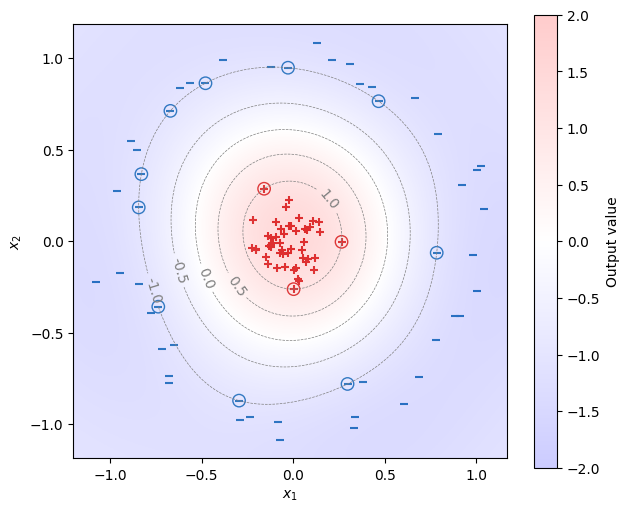

In [24]:
fig, ax = init_graph(X, Y, figsize=(7, 6))
plot_data(ax, X, Y)
plot_support_vectors(ax, X, Y, model.support_, s=80)
draw_heatmap(ax, fig, X, Y, model, step=0.5)
plt.show()

---

[機械学習帳](https://chokkan.github.io/mlnote/) © Copyright 2020-2021 by [岡崎 直観 (Naoaki Okazaki)](https://www.chokkan.org/). この作品は<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">クリエイティブ・コモンズ 表示 - 非営利 - 改変禁止 4.0 国際 ライセンス</a>の下に提供されています。 <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/80x15.png" /></a>　ただし、作品中のコードセル部分は<a rel="license" href="https://opensource.org/licenses/MIT">MITライセンス</a>の下に提供されています。